In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
from mvf_bto.data_loading import load_data
from mvf_bto.constants import * 
from mvf_bto.models.baseline_lstm import BaselineLSTM, LSTMAutoregression
from mvf_bto.preprocessing import create_discharge_inputs
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import MeanSquaredError
from scipy.interpolate import interp1d

import numpy as np
import pandas as pd
import plotly
import plotly.graph_objects as go

## Loading Data

In [37]:
data_path = "/home/amalss/Documents/CMU/Courses/10701/project/data/2017-05-12_batchdata_updated_struct_errorcorrect.mat"
# data_path = "/Users/anoushkabhutani/PycharmProjects/10701-mvf-bto/data/2017-05-12_batchdata_updated_struct_errorcorrect.mat"
# data_path = "/Users/mac/Desktop/CMU/10701MachineLearning/project/10701-mvf-bto-backup/data/2017-05-12_batchdata_updated_struct_errorcorrect.mat"

In [38]:
data = load_data(file_path=data_path, num_cells=4)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:26<00:00,  6.74s/it]


## Preprocessing to create model inputs and targets

In [39]:
train_split = 0.7
test_split = 0.2
# by default uses validation_split = 1 - (train_split + test_split)


In [67]:
datasets = create_discharge_inputs(data, train_split, test_split, forecast_horizon=10, history_window=7)
# Q_eval = np.linspace(0, 1, 

 Data for cell b1c3 is corrupted. Skipping cell.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1178/1178 [00:08<00:00, 145.44it/s]


## Train Model

In [68]:
window_length = datasets["X_train"].shape[1]
n_features = datasets["X_train"].shape[2]
batch_input_shape = (datasets["batch_size"], window_length, n_features)
n_outputs = datasets["y_train"].shape[-1]
nf_steps = datasets["y_train"].shape[1]
# y = datasets["y_train"][:, 0, 0]
# idx = y < 2.9
# weights = np.ones_like(y) * 1
# weights[idx] = 2

In [69]:
print(datasets["X_train"].shape)
print(datasets["y_train"].shape)

(3525, 6, 4)
(3525, 10, 4)


In [70]:
# model = BaselineLSTM(batch_input_shape=batch_input_shape, n_outputs=n_outputs, nf_steps=nf_steps)
from mvf_bto.models.baseline_lstm import BaselineLSTM, LSTMAutoregression

model = LSTMAutoregression(n_outputs=n_outputs, out_steps=10)

In [71]:
model.compile(optimizer="adam", loss="mse", metrics=[MeanSquaredError()])
model.build(batch_input_shape)
model.summary()
es = EarlyStopping(
    monitor="val_mean_squared_error",
    min_delta=0,
    patience=10,
    verbose=1,
    mode="auto",
    restore_best_weights=True,
)

history = model.fit(
    datasets["X_train"],
    datasets["y_train"],
    validation_data=(datasets["X_val"], datasets["y_val"]),
    epochs=250,
    batch_size=datasets["batch_size"],
    shuffle=False,
    callbacks=[es],
    verbose=1,
)

Model: "lstm_autoregression_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_cell_9 (LSTMCell)      multiple                  4736      
                                                                 
 rnn_9 (RNN)                 multiple                  4736      
                                                                 
 dense_9 (Dense)             multiple                  132       
                                                                 
Total params: 4,868
Trainable params: 4,868
Non-trainable params: 0
_________________________________________________________________
Epoch 1/250
1175/1175 [==============================] - 11s 7ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0206 - val_mean_squared_error: 0.0206
Epoch 2/250
1175/1175 [==============================] - 8s 6ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0222 - val_mea

In [72]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=np.linspace(1, 50),
        y=history.history["loss"],
        showlegend=False,
        mode="markers+lines",
    )
)
fig.update_xaxes(title="Epochs")
fig.update_yaxes(title="Loss (MSE)")
fig.update_layout(height=500)

## Parity Plot of Training Error

In [73]:
# random plotting traing error at some interval = skip to not make the plot rendering too slow
batch_size = datasets["batch_size"]
skip = 70

fig = go.Figure()
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], showlegend=False, mode="markers+lines"))
for i in range(0, len(datasets["X_train"]), batch_size * skip):
    df_pred = pd.DataFrame(model.predict(datasets["X_train"][i : i + batch_size], verbose=0)[:, :, 0])
    df_train = pd.DataFrame(datasets["y_train"][i : i + batch_size][:, :, 0])
    fig.add_trace(
        go.Scatter(
            x=df_pred[0].values,
            y=df_train[0].values,
            showlegend=False,
            mode="markers+lines",
        )
    )

fig.update_yaxes(title="Normalized Voltage Target")
fig.update_xaxes(title="Normalized Voltage Prediction")
fig.update_layout(template="simple_white")
fig.update_layout(height=500)

In [52]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], showlegend=False, mode="markers+lines"))
for i in range(0, len(datasets["X_train"]), batch_size * skip):
    df_pred = pd.DataFrame(model.predict(datasets["X_train"][i : i + batch_size], verbose=0)[:, :, 0])
    df_train = pd.DataFrame(datasets["y_train"][i : i + batch_size][:, :, 0])
    fig.add_trace(
        go.Scatter(
            x=df_pred[0].values,
            y=df_train[0].values,
            showlegend=False,
            mode="markers+lines",
        )
    )

fig.update_yaxes(title="Normalized Temperature Target")
fig.update_xaxes(title="Normalized Temperature Prediction")
fig.update_layout(template="simple_white")
fig.update_layout(height=500)

## Parity Plot of Test Error

In [17]:
skip = 20

fig = go.Figure()
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], showlegend=False, mode="markers+lines"))
for i in range(0, len(datasets["X_test"]), batch_size * skip):
    df_pred = pd.DataFrame(model.predict(datasets["X_test"][i : i + batch_size], verbose=0)[:, :, 0])
    df_train = pd.DataFrame(datasets["y_test"][i : i + batch_size][:, :, 0])
    fig.add_trace(
        go.Scatter(
            x=df_pred[0].values,
            y=df_train[0].values,
            showlegend=False,
            mode="markers+lines",
        )
    )

fig.update_yaxes(title="Normalized Voltage Target")
fig.update_xaxes(title="Normalized Voltage Prediction")
fig.update_layout(template="simple_white")

In [18]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], showlegend=False, mode="markers+lines"))
for i in range(0, len(datasets["X_test"]), batch_size * skip):
    df_pred = pd.DataFrame(model.predict(datasets["X_test"][i : i + batch_size], verbose=0)[:, :, 1])
    df_train = pd.DataFrame(datasets["y_test"][i : i + batch_size][:, :, 1])
    fig.add_trace(
        go.Scatter(
            x=df_pred[0].values,
            y=df_train[0].values,
            showlegend=False,
            mode="markers+lines",
        )
    )

fig.update_yaxes(title="Normalized Temperature Target")
fig.update_xaxes(title="Normalized Temperature Prediction")
fig.update_layout(template="simple_white")

## True vs Predicted Traces (Train Set)

In [55]:
symbol_list = ["circle-open", "circle", "triangle-up"]
pallete = plotly.colors.qualitative.Dark24 + plotly.colors.qualitative.T10
pallete = pallete*70000

In [56]:
train_cell_ids = list(datasets['original_train']['Cell'].unique())
test_cell_ids = list(datasets['original_test']['Cell'].unique())
val_cell_ids = list(datasets['original_val']['Cell'].unique())

(1, 6, 4)
(1, 10, 4)


/tmp/ipykernel_1746109/786221669.py:14: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.

/tmp/ipykernel_1746109/786221669.py:19: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.



(0.0, 50.0)

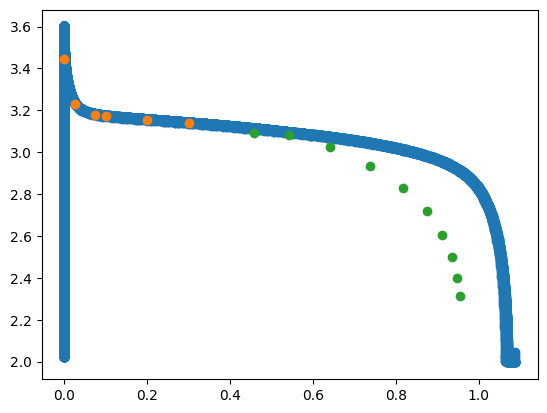

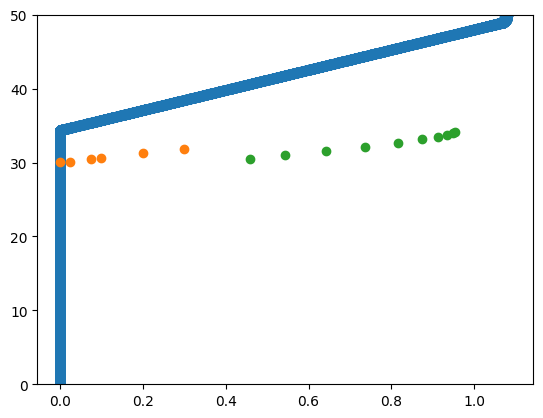

In [112]:
input = datasets["X_train"][0:1]
print(input.shape)
output = model.predict(input, verbose=0)
print(output.shape)

# print(datasets['original_train'].keys())
full_data_V = datasets['original_train'].V
full_data_Qd = datasets['original_train'].Qd
full_data_T = datasets['original_train'].t

# print(full_data)
import matplotlib.pyplot as plt
Q_input = input[0][:, 1]
plt.scatter(full_data_Qd[:50000], full_data_V[:50000])
plt.scatter(Q_input, input[0][:,2]*(VOLTAGE_MAX - VOLTAGE_MIN) + VOLTAGE_MIN)
plt.scatter(output[0][:, 1], output[0][:, 2]*(VOLTAGE_MAX - VOLTAGE_MIN) + VOLTAGE_MIN)

plt.figure()
plt.scatter(full_data_Qd[:50000], full_data_T[:50000])
plt.scatter(Q_input, input[0][:,0]*(TEMPERATURE_MAX - TEMPERATURE_MIN) + TEMPERATURE_MIN)
plt.scatter(output[0][:, 1], output[0][:, 0]*(TEMPERATURE_MAX - TEMPERATURE_MIN) + TEMPERATURE_MIN)
plt.ylim(0, 50)

In [78]:
skip = 500
train_cell_id_idx = 0
last_cycle = 1
current_cycle = 1
opacity_list = [1, 0.6, 0.3]
fig = go.Figure()

print(model(datasets["X_train"]))

for i in range(0, len(datasets["X_train"]), batch_size * skip):
    df_true = pd.DataFrame(datasets["y_train"][i : i + batch_size][:, 0, 0])
    
    last_cycle = current_cycle
    current_cycle = int(datasets["X_train"][i : i + batch_size][0][0][-1]*MAX_CYCLE)
    if current_cycle>740:
        continue
    if last_cycle> current_cycle:
        train_cell_id_idx += 1
    cell_id = train_cell_ids[train_cell_id_idx]
    original_df = datasets["original_train"]
    original_df= original_df[original_df.Cycle==current_cycle]
    original_df= original_df[original_df.Cell==cell_id]
    original_df = original_df[original_df.I < MAX_DISCHARGE_CURRENT]
    original_df = original_df[original_df.I > MIN_DISCHARGE_CURRENT]

    original_df['Qd'] = (original_df['Qd']-original_df['Qd'].min())/(original_df['Qd'].max()-original_df['Qd'].min())

    if len(original_df)< 2:
        continue
    q_new = original_df.Qd.values
    t_new = original_df['t'].values
    time_interpolator = interp1d(x = q_new,  y = t_new, fill_value="extrapolate")
    
    # print(model.predict(datasets["X_train"][i : i + 7], verbose=0), i)
    for j in range(1):
        df_pred = pd.DataFrame(model.predict(datasets["X_train"][i : i + 7], verbose=0)[:, j, 1])
    
        ref_capacities_wrt_nf = REFERENCE_DISCHARGE_CAPACITIES[window_length+j:-nf_steps+j-1]

        prediction_interpolator = interp1d(x = ref_capacities_wrt_nf, 
                                           y = df_pred[0].values*(VOLTAGE_MAX - VOLTAGE_MIN) + VOLTAGE_MIN,
                                           
                                          )
        
        q_j = q_new[q_new>= min(REFERENCE_DISCHARGE_CAPACITIES[window_length+j:-nf_steps+j-1])]
        q_j = q_j[q_j<= max(REFERENCE_DISCHARGE_CAPACITIES[window_length+j:-nf_steps+j-1])]
        t_interp = time_interpolator(REFERENCE_DISCHARGE_CAPACITIES[window_length:-nf_steps-1])
        if j==0:
            q_j0 = q_j
        V_pred = prediction_interpolator(q_j)
        fig.add_trace(
            go.Scatter(
                x=time_interpolator(q_j),
                y=V_pred,
                showlegend=True,
                mode="lines",
                line_dash="dash",
                name = "Interpolated Predictions",
                marker_color=pallete[i],
                opacity=opacity_list[j]
            )
        )
        
        fig.add_trace(
            go.Scatter(
                x=time_interpolator(ref_capacities_wrt_nf),
                y=df_pred[0].values*(VOLTAGE_MAX - VOLTAGE_MIN) + VOLTAGE_MIN,
                showlegend=True,
                mode="markers",
                name = f"Predictions Forecast Horizon {j+1}",
                marker_color=pallete[i],
                marker_symbol = symbol_list[j],
                marker_size=8,
                marker_opacity=opacity_list[j]
            )
        )

    odf = original_df[original_df.Qd > q_j0.min()]
    odf = odf[odf.Qd < q_j.max()]
    fig.add_trace(
        go.Scatter(
            x=odf['t'],
            y=odf['V'],
            showlegend=True,
            mode="lines",
            name = f"{cell_id} Cycle {current_cycle}",
            line_color=pallete[i]
        )
    )


fig.update_yaxes(title="Voltage [V]", showgrid=True)
fig.update_xaxes(title="Times (min)", showgrid=True)
fig.update_layout(template="simple_white")
fig.update_layout(height=500)

tf.Tensor(
[[[0.46112865 0.45785218 0.7458216  0.41859758]
  [0.49677157 0.54280406 0.7379992  0.46186006]
  [0.5399587  0.641686   0.70162    0.479034  ]
  ...
  [0.6953719  0.9350303  0.3742256  0.49087593]
  [0.71053314 0.94800454 0.31275102 0.49258694]
  [0.72221655 0.954408   0.25740117 0.49422723]]

 [[0.49641094 0.53676176 0.7068176  0.40891394]
  [0.539293   0.632225   0.69054794 0.4518109 ]
  [0.5850891  0.7311406  0.6449421  0.46880886]
  ...
  [0.7157051  0.9514329  0.31964427 0.49283147]
  [0.7267711  0.9575905  0.26379174 0.49532497]
  [0.73494875 0.959325   0.21407604 0.497155  ]]

 [[0.5367257  0.6231549  0.6696149  0.40415898]
  [0.58263755 0.7215989  0.64314777 0.44523305]
  [0.626603   0.81052333 0.5893877  0.4623642 ]
  ...
  [0.7313692  0.96184653 0.27257052 0.4953558 ]
  [0.7390398  0.9631588  0.22191608 0.4979959 ]
  [0.74434435 0.9615708  0.1772317  0.49962425]]

 ...

 [[0.54642224 0.42311907 0.7926007  0.5112271 ]
  [0.5820334  0.5327594  0.79820246 0.53092873]

In [59]:
train_cell_id_idx = 0
last_cycle = 1
current_cycle = 1

fig = go.Figure()
for i in range(0, len(datasets["X_train"]), batch_size * skip):
    df_true = pd.DataFrame(datasets["y_train"][i : i + batch_size][:, 0, 1])
    
    last_cycle = current_cycle
    current_cycle = int(datasets["X_train"][i : i + batch_size][0][0][-1]*MAX_CYCLE)
    if current_cycle>740:
        continue
    if last_cycle> current_cycle:
        train_cell_id_idx += 1
        
    cell_id = train_cell_ids[train_cell_id_idx]
    original_df = datasets["original_train"]

    original_df= original_df[original_df.Cycle==current_cycle]
    original_df= original_df[original_df.Cell==cell_id]
    original_df = original_df[original_df.I < MAX_DISCHARGE_CURRENT]
    original_df = original_df[original_df.I > MIN_DISCHARGE_CURRENT]

    original_df['Qd'] = (original_df['Qd']-original_df['Qd'].min())/(original_df['Qd'].max()-original_df['Qd'].min())

    if len(original_df)< 2:
        continue
    q_new = original_df.Qd.values
    t_new = original_df['t'].values
    time_interpolator = interp1d(x = q_new,  y = t_new, fill_value="extrapolate")
    
    
    for j in range(1):
        df_pred = pd.DataFrame(model.predict(datasets["X_train"][i : i + batch_size], verbose=0)[:, j, 1])
    
        ref_capacities_wrt_nf = REFERENCE_DISCHARGE_CAPACITIES[window_length+j:-nf_steps+j-1]

        prediction_interpolator = interp1d(x = ref_capacities_wrt_nf, 
                                           y = df_pred[0].values*(TEMPERATURE_MAX - TEMPERATURE_MIN) + TEMPERATURE_MIN,
                                           
                                          )
        
        q_j = q_new[q_new>= min(REFERENCE_DISCHARGE_CAPACITIES[window_length+j:-nf_steps+j-1])]
        q_j = q_j[q_j<= max(REFERENCE_DISCHARGE_CAPACITIES[window_length+j:-nf_steps+j-1])]
        t_interp = time_interpolator(REFERENCE_DISCHARGE_CAPACITIES[window_length:-nf_steps-1])
        if j==0:
            q_j0 = q_j
        V_pred = prediction_interpolator(q_j)
        fig.add_trace(
            go.Scatter(
                x=time_interpolator(q_j),
                y=V_pred,
                showlegend=True,
                mode="lines",
                line_dash="dash",
                name = "Interpolated Predictions",
                marker_color=pallete[i//skip],
                opacity=opacity_list[j]
            )
        )
        
        fig.add_trace(
            go.Scatter(
                x=time_interpolator(ref_capacities_wrt_nf),
                y=df_pred[0].values*(TEMPERATURE_MAX - TEMPERATURE_MIN) + TEMPERATURE_MIN,
                showlegend=True,
                mode="markers",
                name = f"Predictions Forecast Horizon {j+1}",
                marker_color=pallete[i//skip],
                marker_symbol = symbol_list[j],
                marker_size=8,
            )
        )


    odf = original_df[original_df.Qd > q_j0.min()]
    odf = odf[odf.Qd < q_j.max()]
    fig.add_trace(
        go.Scatter(
            x=odf['t'],
            y=odf['temp'],
            showlegend=True,
            mode="lines",
            name = f"{cell_id} Cycle {current_cycle}",
            line_color=pallete[i//skip]
        )
    )


fig.update_yaxes(title="Temperature [°C]", showgrid=True)
fig.update_xaxes(title="Times (min)", showgrid=True)
fig.update_layout(template="simple_white")
fig.update_layout(height=500)

## True vs Predicted Traces (Test Set)

In [23]:
skip = 300
test_cell_id_idx = 0
last_cycle = 1
current_cycle = 1
opacity_list = [1, 0.6, 0.3]
fig = go.Figure()
for i in range(0, len(datasets["X_test"]), batch_size * skip):
    df_true = pd.DataFrame(datasets["y_test"][i : i + batch_size][:, 0, 0])
    
    last_cycle = current_cycle
    current_cycle = int(datasets["X_test"][i : i + batch_size][0][0][-1]*MAX_CYCLE)

    if last_cycle> current_cycle:
        test_cell_id_idx += 1
        
    cell_id = test_cell_ids[test_cell_id_idx]
    original_df = datasets["original_test"]

    original_df= original_df[original_df.Cycle==current_cycle]
    original_df= original_df[original_df.Cell==cell_id]
    original_df = original_df[original_df.I < MAX_DISCHARGE_CURRENT]
    original_df = original_df[original_df.I > MIN_DISCHARGE_CURRENT]

    original_df['Qd'] = (original_df['Qd']-original_df['Qd'].min())/(original_df['Qd'].max()-original_df['Qd'].min())

    if len(original_df)< 2:
        continue
    q_new = original_df.Qd.values
    t_new = original_df['t'].values
    time_interpolator = interp1d(x = q_new,  y = t_new, fill_value="extrapolate")
    
    
    for j in range(nf_steps):
        df_pred = pd.DataFrame(model.predict(datasets["X_test"][i : i + batch_size], verbose=0)[:, j, 0])
    
        ref_capacities_wrt_nf = REFERENCE_DISCHARGE_CAPACITIES[window_length+j:-nf_steps+j-1]

        prediction_interpolator = interp1d(x = ref_capacities_wrt_nf, 
                                           y = df_pred[0].values*(VOLTAGE_MAX - VOLTAGE_MIN) + VOLTAGE_MIN,
                                           
                                          )
        
        q_j = q_new[q_new>= min(REFERENCE_DISCHARGE_CAPACITIES[window_length+j:-nf_steps+j-1])]
        q_j = q_j[q_j<= max(REFERENCE_DISCHARGE_CAPACITIES[window_length+j:-nf_steps+j-1])]
        t_interp = time_interpolator(REFERENCE_DISCHARGE_CAPACITIES[window_length:-nf_steps-1])
        if j==0:
            q_j0 = q_j
        V_pred = prediction_interpolator(q_j)
        fig.add_trace(
            go.Scatter(
                x=time_interpolator(q_j),
                y=V_pred,
                showlegend=True,
                mode="lines",
                line_dash="dash",
                name = "Interpolated Predictions",
                marker_color=pallete[i//skip],
                opacity=opacity_list[j]
            )
        )
        
        fig.add_trace(
            go.Scatter(
                x=time_interpolator(ref_capacities_wrt_nf),
                y=df_pred[0].values*(VOLTAGE_MAX - VOLTAGE_MIN) + VOLTAGE_MIN,
                showlegend=True,
                mode="markers",
                name = f"Predictions Forecast Horizon {j+1}",
                marker_color=pallete[i//skip],
                marker_symbol = symbol_list[j],
                marker_size=8,
                marker_opacity=opacity_list[j]
            )
        )


    odf = original_df[original_df.Qd > q_j0.min()]
    odf = odf[odf.Qd < q_j.max()]
    fig.add_trace(
        go.Scatter(
            x=odf['t'],
            y=odf['V'],
            showlegend=True,
            mode="lines",
            name = f"{cell_id} Cycle {current_cycle}",
            line_color=pallete[i//skip]
        )
    )


fig.update_yaxes(title="Voltage [V]", showgrid=True)
fig.update_xaxes(title="Times (min)", showgrid=True)
fig.update_layout(template="simple_white")

In [24]:
test_cell_id_idx = 0
last_cycle = 1
current_cycle = 1

fig = go.Figure()
for i in range(0, len(datasets["X_test"]), batch_size * skip):
    
    last_cycle = current_cycle
    current_cycle = int(datasets["X_test"][i : i + batch_size][0][0][-1]*MAX_CYCLE)
    
    if last_cycle> current_cycle:
        test_cell_id_idx += 1
        
    cell_id = test_cell_ids[test_cell_id_idx]
    original_df = datasets["original_test"]

    original_df= original_df[original_df.Cycle==current_cycle]
    original_df= original_df[original_df.Cell==cell_id]
    original_df = original_df[original_df.I < MAX_DISCHARGE_CURRENT]
    original_df = original_df[original_df.I > MIN_DISCHARGE_CURRENT]

    original_df['Qd'] = (original_df['Qd']-original_df['Qd'].min())/(original_df['Qd'].max()-original_df['Qd'].min())

    if len(original_df)< 2:
        continue
    q_new = original_df.Qd.values
    t_new = original_df['t'].values
    time_interpolator = interp1d(x = q_new,  y = t_new, fill_value="extrapolate")
    
    
    for j in range(nf_steps):
        df_pred = pd.DataFrame(model.predict(datasets["X_test"][i : i + batch_size], verbose=0)[:, j, 1])
    
        ref_capacities_wrt_nf = REFERENCE_DISCHARGE_CAPACITIES[window_length+j:-nf_steps+j-1]

        prediction_interpolator = interp1d(x = ref_capacities_wrt_nf, 
                                           y = df_pred[0].values*(TEMPERATURE_MAX - TEMPERATURE_MIN) + TEMPERATURE_MIN,
                                           
                                          )
        
        q_j = q_new[q_new>= min(REFERENCE_DISCHARGE_CAPACITIES[window_length+j:-nf_steps+j-1])]
        q_j = q_j[q_j<= max(REFERENCE_DISCHARGE_CAPACITIES[window_length+j:-nf_steps+j-1])]
        t_interp = time_interpolator(REFERENCE_DISCHARGE_CAPACITIES[window_length:-nf_steps-1])
        if j==0:
            q_j0 = q_j
        V_pred = prediction_interpolator(q_j)
        fig.add_trace(
            go.Scatter(
                x=time_interpolator(q_j),
                y=V_pred,
                showlegend=True,
                mode="lines",
                line_dash="dash",
                name = "Interpolated Predictions",
                marker_color=pallete[i//skip],
                opacity=opacity_list[j]
            )
        )
        
        fig.add_trace(
            go.Scatter(
                x=time_interpolator(ref_capacities_wrt_nf),
                y=df_pred[0].values*(TEMPERATURE_MAX - TEMPERATURE_MIN) + TEMPERATURE_MIN,
                showlegend=True,
                mode="markers",
                name = f"Predictions Forecast Horizon {j+1}",
                marker_color=pallete[i//skip],
                marker_symbol = symbol_list[j],
                marker_size=8,
#                 marker_opacity=opacity_list[j]
            )
        )


    odf = original_df[original_df.Qd > q_j0.min()]
    odf = odf[odf.Qd < q_j.max()]
    fig.add_trace(
        go.Scatter(
            x=odf['t'],
            y=odf['temp'],
            showlegend=True,
            mode="lines",
            name = f"{cell_id} Cycle {current_cycle}",
            line_color=pallete[i//skip]
        )
    )


fig.update_yaxes(title="Temperature [°C]", showgrid=True)
fig.update_xaxes(title="Times (min)", showgrid=True)
fig.update_layout(template="simple_white")

## Metrics

In [25]:
def error_calculation(model, datasets, error_function):
    results = {}
    batch_size = datasets["batch_size"]
    n_outputs = datasets["y_train"].shape[-1]
    nf_steps = datasets["y_train"].shape[1]
    for dset in ["train", "test"]:
        skip = 200 if dset == "train"  else 50
        for output in range(n_outputs):
            for step in range(nf_steps):
                collector = []
                for i in range(0, len(datasets[f"X_{dset}"]), batch_size*skip):
                    true = datasets[f"y_{dset}"][i : i + batch_size][:, j, output]
                    pred = model.predict(datasets[f"X_{dset}"][i : i + batch_size], verbose=0)[:, j, output]
                    error = error_function(true, pred)
                    collector.append(error)
                results[f"{dset}_output{output}_forecasthorizon{step}"] =sum(collector)/len(collector)
                         
    return results

In [26]:
root_mean_square_error = lambda y_true, y_pred : np.sqrt(((y_true - y_pred)**2).sum()/len(y_true))
mean_absolute_error = lambda y_true, y_pred : abs(y_true - y_pred).sum()/len(y_true)
mean_absolute_percent_error = lambda y_true, y_pred : (abs(y_true - y_pred)/y_true).sum()/len(y_true)

In [27]:
error_calculation(model, datasets, error_function=mean_absolute_error)

{'train_output0_forecasthorizon0': 0.015642870535682644,
 'train_output0_forecasthorizon1': 0.01628209448411539,
 'train_output1_forecasthorizon0': 0.022843990524352518,
 'train_output1_forecasthorizon1': 0.02269231515245586,
 'test_output0_forecasthorizon0': 0.009784683579229257,
 'test_output0_forecasthorizon1': 0.012058892583094609,
 'test_output1_forecasthorizon0': 0.026131516326053747,
 'test_output1_forecasthorizon1': 0.026132404985184696}